### Data Cleaning

In [2]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, GridSearchCV, ParameterGrid
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, accuracy_score, recall_score, precision_recall_curve
import xgboost as xgb
import itertools as it
import time as time
import pickle
import warnings
warnings.filterwarnings("ignore")

pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option('display.float_format', lambda x: '%.4f' % x)

train = pd.read_csv('data/train.csv', index_col = 0)
test = pd.read_csv('data/test.csv', index_col = 0)

def data_prep(df):
    df["satisfaction"] = df["satisfaction"].map({'neutral or dissatisfied': 0, 'satisfied':1})
    df = df.dropna()
    df = df.drop(columns=["id"])
    df.columns = df.columns.str.replace(' ', '_')
    df.columns = df.columns.str.replace('/', '_')
    df.columns = df.columns.str.replace('-', '_')
    df['Type_of_Travel'] = df['Type_of_Travel'].astype('string')
    df['Class'] = df['Class'].astype('string')
    df['Gender'] = df['Gender'].astype('string')
    df['Customer_Type'] = df['Customer_Type'].astype('string')
    return df

train = data_prep(train)
test = data_prep(test)

categorical_columns = list(train.select_dtypes('string').columns)
train = pd.get_dummies(train, columns = categorical_columns, drop_first = False)
test = pd.get_dummies(test, columns = categorical_columns, drop_first = False)

train = train.dropna()
test = test.dropna()

print(f"Train size: {train.shape}")
print(f"Test size: {test.shape}")

X = train.drop(columns=["satisfaction"])
y = train["satisfaction"]
Xtest = test.drop(columns=["satisfaction"])
ytest = test["satisfaction"]

train[:3]

Train size: (103594, 28)
Test size: (25893, 28)


,Age,Flight_Distance,Inflight_wifi_service,Departure_Arrival_time_convenient,Ease_of_Online_booking,Gate_location,Food_and_drink,Online_boarding,Seat_comfort,Inflight_entertainment,On_board_service,Leg_room_service,Baggage_handling,Checkin_service,Inflight_service,Cleanliness,Departure_Delay_in_Minutes,Arrival_Delay_in_Minutes,satisfaction,Gender_Female,Gender_Male,Customer_Type_Loyal Customer,Customer_Type_disloyal Customer,Type_of_Travel_Business travel,Type_of_Travel_Personal Travel,Class_Business,Class_Eco,Class_Eco Plus
0,13,460,3,4,3,1,5,3,5,5,4,3,4,4,5,5,25,18.0000,0,0,1,1,0,0,1,0,0,1
1,25,235,3,2,3,3,1,3,1,1,1,5,3,1,4,1,1,6.0000,0,0,1,0,1,1,0,1,0,0
2,26,1142,2,2,2,2,5,5,5,5,4,3,4,4,4,5,0,0.0000,1,1,0,1,0,1,0,1,0,0


In [4]:
def save_model(model, filename):
    # save the model to disk
    filename = f'models/{filename}.sav'
    pickle.dump(model, open(filename, 'wb'))
    
def load_model(filename):
    # load the model from disk
    loaded_model = pickle.load(open(f'models/{filename}.sav', 'rb'))
    return loaded_model

def precision_cutoff(actual, pred, cutoff=0.5):
    bins=np.array([0,cutoff,1])
    cm = np.histogram2d(actual, pred, bins=bins)[0]
    precision = (cm[1,1])/(cm[0,1]+cm[1,1])
    return precision

def recall_cutoff(actual, pred, cutoff=0.5):
    bins=np.array([0,cutoff,1])
    cm = np.histogram2d(actual, pred, bins=bins)[0]
    recall = (cm[1,1])/(cm[1,0]+cm[1,1])
    return recall

def accuracy_cutoff(actual, pred, cutoff=0.5):
    bins=np.array([0,cutoff,1])
    cm = np.histogram2d(actual, pred, bins=bins)[0]
    accuracy = (cm[0,0]+cm[1,1])/cm.sum()
    return accuracy

def precision_accuracy_cutoff(actual, pred, cutoff=0.5):
    bins=np.array([0,cutoff,1])
    cm = np.histogram2d(actual, pred, bins=bins)[0]
    precision = (cm[1,1])/(cm[0,1]+cm[1,1])
    accuracy = (cm[0,0]+cm[1,1])/cm.sum()
    return precision, accuracy

def plot_precision_accuracy_vs_threshold(precisions, accuracies, thresholds):
        plt.figure(figsize=(8, 8))
        plt.title("Training Precision and Accuracy vs Threshold")
        plt.plot(thresholds, precisions, "b--", label="Precision")
        plt.plot(thresholds, accuracies, "g-", label="Accuracy")
        plt.plot(thresholds[accuracies.index(max(accuracies))], max(accuracies), "ro")
        plt.text(thresholds[accuracies.index(max(accuracies))], max(accuracies), 
                 f"({round(thresholds[accuracies.index(max(accuracies))], 4)}, {round(max(accuracies), 4)}, {round(precisions[accuracies.index(max(accuracies))], 4)})")
        plt.plot(thresholds[precisions.index(max(precisions))], max(precisions), "yo")
        plt.text(thresholds[precisions.index(max(precisions))], max(precisions), 
                 f"({round(thresholds[precisions.index(max(precisions))], 4)}, {round(accuracies[precisions.index(max(precisions))], 4)}, {round(max(precisions), 4)})")
        plt.ylabel("Score")
        plt.xlabel("Decision Threshold")
        plt.legend(loc='best')
        
def find_cutoff(model):   
    
    ypred = model.predict_proba(X)[:, 1]
    thresholds = precision_recall_curve(y, ypred)[2]

    precisions = []
    accuracies = []
    
    for threshold in thresholds:
        precision, accuracy = precision_accuracy_cutoff(y, ypred, cutoff=threshold)
        precisions.append(precision)
        accuracies.append(accuracy)
        
    plot_precision_accuracy_vs_threshold(precisions, accuracies, thresholds)
    
    return thresholds[precisions.index(max(precisions))]

### a) Random Forest

In [7]:
oob_precision = {}
for i in [50]:
    for j in [14]:
        for k in [28, 29, 30, 31, 32]:
            for l in [1]:
                model = RandomForestClassifier(n_estimators = i, max_features = j, min_samples_split = k, min_samples_leaf = l, n_jobs=-1, random_state=1, oob_score=True).fit(X, y)
                oob_precision[i, j, k, l] = precision_cutoff(y, pd.Series(model.oob_decision_function_[:,1]))

print(f"Precision on train data: {oob_precision[max(oob_precision, key=oob_precision.get)]}\nParameters: {max(oob_precision, key=oob_precision.get)}\n")

Precision on train data: 97.39933658896157
Parameters: (50, 14, 30, 1)



In [8]:
params = max(oob_precision, key=oob_precision.get)
rf_params = {'n_estimators': 500, 'max_features': params[1], 'min_samples_split': params[2], 'min_samples_leaf': params[3]}
m1 = RandomForestClassifier(**rf_params, n_jobs=-1, random_state=1, oob_score=True)
model = m1.fit(X, y)
pred = model.predict(Xtest)

print(f"Random forest model -- Precision on test data: {precision_score(y_true = ytest, y_pred = pred)}")
print(f"Random forest model -- Recall on test data: {recall_score(y_true = ytest, y_pred = pred)}")
print(f"Random forest model -- Accuracy on test data: {accuracy_score(y_true = ytest, y_pred = pred)}")
print("Random forest model -- Cutoff on test data: 0.5")
    
save_model(model, 'rf')

Random forest model -- Precision on test data: 0.9725667722951562
Random forest model -- Recall on test data: 0.9451825780906291
Random forest model -- Accuracy on test data: 0.9642374386899935
Random forest model -- Cutoff on test data: 0.5


Random forest model -- Precision on test data: 0.9990712074303405
Random forest model -- Recall on test data: 0.8518257809062912
Random forest model -- Accuracy on test data: 0.9346155331556791
Random forest model -- Cutoff on test data: 0.9126333919479468


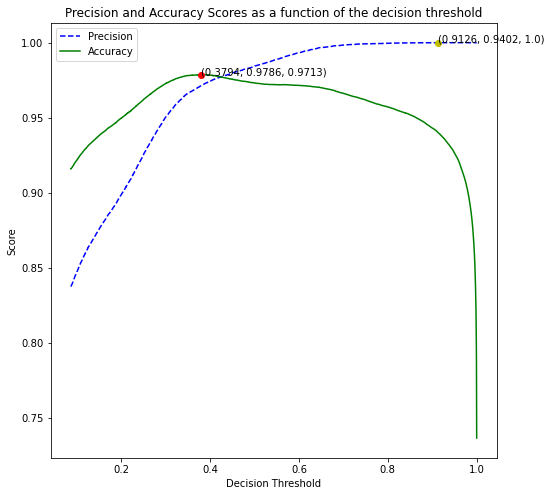

In [13]:
cutoff = find_cutoff(model)
plt.savefig('images/rf.jpg')
# We use the cutoff where precision is maximized on training data (yellow point, first value of 3)
pred = model.predict_proba(Xtest)[:, 1]

print(f"Random forest model -- Precision on test data: {precision_cutoff(ytest, pred, cutoff = cutoff)}")
print(f"Random forest model -- Recall on test data: {recall_cutoff(ytest, pred, cutoff = cutoff)}")
print(f"Random forest model -- Accuracy on test data: {accuracy_cutoff(ytest, pred, cutoff = cutoff)}")
print(f"Random forest model -- Cutoff on test data: {cutoff}")

### b) AdaBoost

In [6]:
model = AdaBoostClassifier(random_state = 1)
grid = dict()
grid['n_estimators'] = [450, 500, 550]
grid['learning_rate'] = [0.025, 0.05, 0.075]
grid['base_estimator'] = [DecisionTreeClassifier(max_depth=5),
                         DecisionTreeClassifier(max_depth=6)]

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, 
                           verbose=1, scoring=['precision', 'accuracy'], refit='precision')
grid_result = grid_search.fit(X, y)
print("Best Training Precision: %f\nParameters: %s" % (grid_result.best_score_, grid_result.best_params_))

Fitting 3 folds for each of 18 candidates, totalling 54 fits
Best Training Precision: 0.974918
Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=6), 'learning_rate': 0.025, 'n_estimators': 450}


In [9]:
params = grid_result.best_params_
m2 = AdaBoostClassifier(**params, random_state=1)
# model = load_model('ada')
model = grid_result
pred = model.predict(Xtest)

print(f"Adaptive boosting model -- Precision on test data: {precision_score(y_true = ytest, y_pred = pred)}")
print(f"Adaptive boosting model -- Recall on test data: {recall_score(y_true = ytest, y_pred = pred)}")
print(f"Adaptive boosting model -- Accuracy on test data: {accuracy_score(y_true = ytest, y_pred = pred)}")
print("Adaptive boosting model -- Cutoff on test data: 0.5")

save_model(model, 'ada')

Adaptive boosting model -- Precision on test data: 0.9744406039657996
Adaptive boosting model -- Recall on test data: 0.9426308842938848
Adaptive boosting model -- Accuracy on test data: 0.9639670953539566
Adaptive boosting model -- Cutoff on test data: 0.5


Adaptive boosting model -- Precision on test data: 0.9979014689717198
Adaptive boosting model -- Recall on test data: 0.8786625604927408
Adaptive boosting model -- Accuracy on test data: 0.9459313327926466
Adaptive boosting model -- Cutoff on test data: 0.5714002413880679


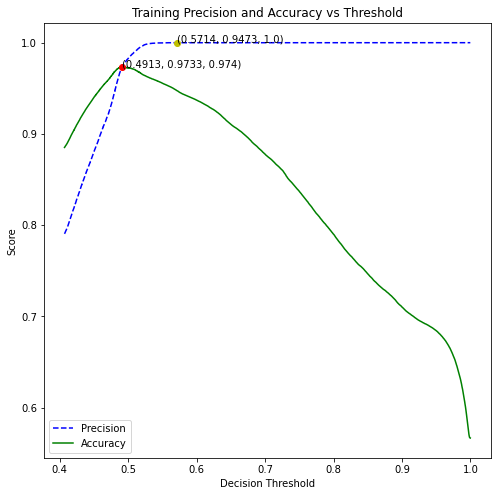

In [8]:
cutoff = find_cutoff(model)
plt.savefig('images/ada.jpg')
# We use the cutoff where precision is maximized on training data (yellow point, first value of 3)
pred = model.predict_proba(Xtest)[:, 1]

print(f"Adaptive boosting model -- Precision on test data: {precision_cutoff(ytest, pred, cutoff = cutoff)}")
print(f"Adaptive boosting model -- Recall on test data: {recall_cutoff(ytest, pred, cutoff = cutoff)}")
print(f"Adaptive boosting model -- Accuracy on test data: {accuracy_cutoff(ytest, pred, cutoff = cutoff)}")
print(f"Adaptive boosting model -- Cutoff on test data: {cutoff}")

### c) Gradient Boost 

In [11]:
model = GradientBoostingClassifier(random_state=1)
grid = dict()
grid['n_estimators'] = [250, 300]
grid['learning_rate'] = [0.01, 0.05]
grid['max_depth'] = [6]
grid['subsample'] = [0.5,1.0]

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, 
                           verbose=1, scoring=['precision','accuracy'], refit='precision')
grid_result = grid_search.fit(X, y)
print("Best Training Precision: %f\nBest Parameters: %s" % (grid_result.best_score_, grid_result.best_params_))

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best Training Precision: 0.973097
Best Parameters: {'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 300, 'subsample': 1.0}


In [12]:
params = grid_result.best_params_
m3 = GradientBoostingClassifier(**params,random_state=1)
# model = load_model('gb')
model = grid_result
pred = model.predict(Xtest)

print(f"Gradient boosting model -- Precision on test data: {precision_score(y_true = ytest, y_pred = pred)}")
print(f"Gradient boosting model -- Recall on test data: {recall_score(y_true = ytest, y_pred = pred)}")
print(f"Gradient boosting model -- Accuracy on test data: {accuracy_score(y_true = ytest, y_pred = pred)}")
print("Gradient boosting model -- Cutoff on test data: 0.5")

save_model(model, 'gb')

Gradient boosting model -- Precision on test data: 0.9725444001449801
Gradient boosting model -- Recall on test data: 0.9443906731192256
Gradient boosting model -- Accuracy on test data: 0.9638898544008033
Gradient boosting model -- Cutoff on test data: 0.5


Gradient boosting model -- Precision on test data: 0.9998811645870469
Gradient boosting model -- Recall on test data: 0.7403431588209415
Gradient boosting model -- Accuracy on test data: 0.8859923531456378
Gradient boosting model -- Cutoff on test data: 0.9900664567731479


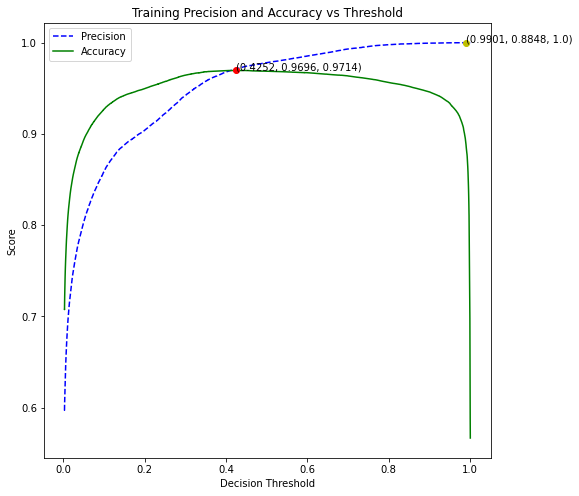

In [13]:
cutoff = find_cutoff(model)
plt.savefig('images/gb.jpg')
# We use the cutoff where precision is maximized on training data (yellow point, first value of 3)
pred = model.predict_proba(Xtest)[:, 1]

print(f"Gradient boosting model -- Precision on test data: {precision_cutoff(ytest, pred, cutoff = cutoff)}")
print(f"Gradient boosting model -- Recall on test data: {recall_cutoff(ytest, pred, cutoff = cutoff)}")
print(f"Gradient boosting model -- Accuracy on test data: {accuracy_cutoff(ytest, pred, cutoff = cutoff)}")
print(f"Gradient boosting model -- Cutoff on test data: {cutoff}")

### d) XGBoost

In [23]:
model = xgb.XGBClassifier(random_state=1)
grid = {'gamma': [0.25],
        'learning_rate': [0.1, 0.001],
        'max_depth': [9],
        'n_estimators': [100, 1000],
        'reg_lambda': [0],
        'scale_pos_weight': [1]}

cv = StratifiedKFold(n_splits=3,shuffle=True,random_state=1)
grid_search = GridSearchCV(estimator=model,param_grid = grid,verbose = 1,n_jobs=-1,
                           cv = cv, scoring=['precision','accuracy'], refit='precision')
grid_result = grid_search.fit(X,y, eval_metric = 'logloss')
print("Best Training Precision: %f\nBest Parameters: %s" % (grid_result.best_score_, grid_result.best_params_))

Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best Training Precision: 0.972061
Best Parameters: {'gamma': 0.25, 'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 100, 'reg_lambda': 0, 'scale_pos_weight': 1}


In [24]:
params = grid_result.best_params_
m4 = xgb.XGBClassifier(**params,random_state=1)
# model = load_model('xgb')
model = grid_result
pred = model.predict(Xtest)

print(f"Extreme gradient boosting model -- Precision on test data: {precision_score(y_true = ytest, y_pred = pred)}")
print(f"Extreme gradient boosting model -- Recall on test data: {recall_score(y_true = ytest, y_pred = pred)}")
print(f"Extreme gradient boosting model -- Accuracy on test data: {accuracy_score(y_true = ytest, y_pred = pred)}")
print("Extreme gradient boosting model -- Cutoff on test data: 0.5")

save_model(model, 'xgb')

Extreme gradient boosting model -- Precision on test data: 0.972046318074905
Extreme gradient boosting model -- Recall on test data: 0.9454465464144303
Extreme gradient boosting model -- Accuracy on test data: 0.9641215772602634
Extreme gradient boosting model -- Cutoff on test data: 0.5


Extreme gradient boosting model -- Precision on test data: 0.9991920008079992
Extreme gradient boosting model -- Recall on test data: 0.8704795424549054
Extreme gradient boosting model -- Accuracy on test data: 0.9428416946665121
Extreme gradient boosting model -- Cutoff on test data: 0.9480050206184387


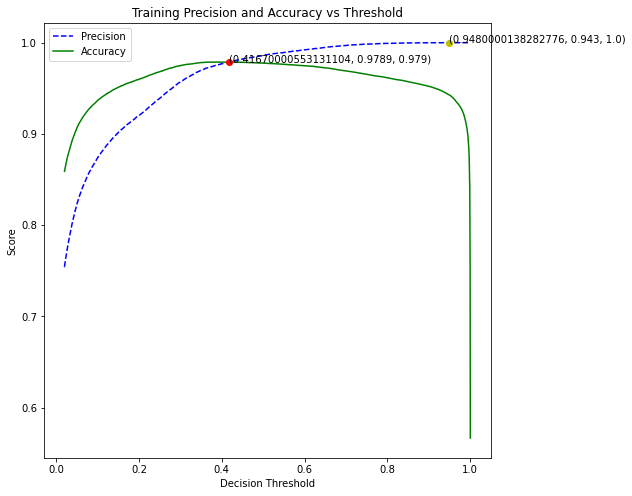

In [25]:
cutoff = find_cutoff(model)
plt.savefig('images/xgb.jpg')
# We use the cutoff where precision is maximized on training data (yellow point, first value of 3)
pred = model.predict_proba(Xtest)[:, 1]

print(f"Extreme gradient boosting model -- Precision on test data: {precision_cutoff(ytest, pred, cutoff = cutoff)}")
print(f"Extreme gradient boosting model -- Recall on test data: {recall_cutoff(ytest, pred, cutoff = cutoff)}")
print(f"Extreme gradient boosting model -- Accuracy on test data: {accuracy_cutoff(ytest, pred, cutoff = cutoff)}")
print(f"Extreme gradient boosting model -- Cutoff on test data: {cutoff}")

### 1) Voting ensemble

#### Soft

In [28]:
en1 = VotingClassifier(estimators = [('rf',m1), ('ada',m2), ('gb',m3), ('xgb',m4)], voting = 'hard')
model = en1.fit(X,y)
pred = model.predict(Xtest)

print(f"Soft voting model -- Precision on test data: {precision_score(y_true = ytest, y_pred = pred)}")
print(f"Soft voting model -- Recall on test data: {recall_score(y_true = ytest, y_pred = pred)}")
print(f"Soft voting model -- Accuracy on test data: {accuracy_score(y_true = ytest, y_pred = pred)}")

save_model(model, 'voting_soft')

[01:10:54] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Soft voting model -- Precision on test data: 0.9774552756480467
Soft voting model -- Recall on test data: 0.9422789265288165
Soft voting model -- Accuracy on test data: 0.9651257096512571
Soft voting model -- Cutoff on test data: 0.5


#### Hard

In [29]:
en2 = VotingClassifier(estimators = [('rf',m1), ('ada',m2), ('gb',m3), ('xgb',m4)], voting = 'soft')
model = en2.fit(X,y)
pred = model.predict(Xtest)

print(f"Hard voting model -- Precision on test data: {precision_score(y_true = ytest, y_pred = pred)}")
print(f"Hard voting model -- Recall on test data: {recall_score(y_true = ytest, y_pred = pred)}")
print(f"Hard voting model -- Accuracy on test data: {accuracy_score(y_true = ytest, y_pred = pred)}")
print("Hard voting model -- Cutoff on test data: 0.5")

save_model(model, 'voting_hard')

[01:16:56] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Hard voting model -- Precision on test data: 0.9744985933387784
Hard voting model -- Recall on test data: 0.944830620325561
Hard voting model -- Accuracy on test data: 0.9649326072683737
Hard voting model -- Cutoff on test data: 0.5


Hard voting model -- Precision on test data: 0.9991007194244604
Hard voting model -- Recall on test data: 0.8798064232292125
Hard voting model -- Accuracy on test data: 0.9468968447070637
Hard voting model -- Cutoff on test data: 0.81913270032123


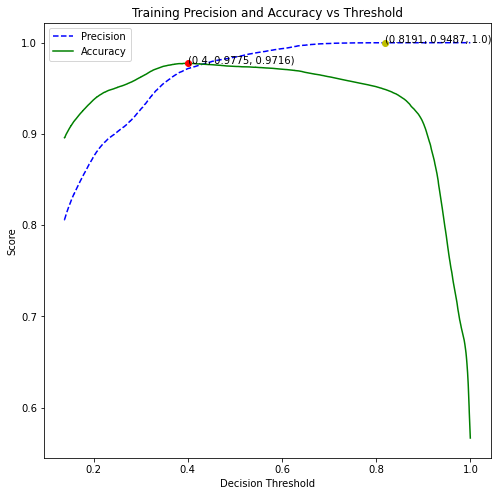

In [31]:
cutoff = find_cutoff(model)
plt.savefig('images/voting_hard.jpg')
# We use the cutoff where precision is maximized on training data (yellow point, first value of 3)
pred = model.predict_proba(Xtest)[:, 1]

print(f"Hard voting model -- Precision on test data: {precision_cutoff(ytest, pred, cutoff = cutoff)}")
print(f"Hard voting model -- Recall on test data: {recall_cutoff(ytest, pred, cutoff = cutoff)}")
print(f"Hard voting model -- Accuracy on test data: {accuracy_cutoff(ytest, pred, cutoff = cutoff)}")
print(f"Hard voting model -- Cutoff on test data: {cutoff}")

### 2) Stacking ensemble

#### Linear

In [36]:
en3 = StackingClassifier(estimators = [('rf',m1), ('ada',m2), ('gb',m3), ('xgb',m4)],
                        final_estimator=LogisticRegression(random_state=1,max_iter=10000),n_jobs=-1,
                        cv = StratifiedKFold(n_splits=3,shuffle=True,random_state=1))
model = en3.fit(X,y)
pred = model.predict(Xtest)

print(f"Linear stacking model -- Precision on test data: {precision_score(y_true = ytest, y_pred = pred)}")
print(f"Linear stacking model -- Recall on test data: {recall_score(y_true = ytest, y_pred = pred)}")
print(f"Linear stacking model -- Accuracy on test data: {accuracy_score(y_true = ytest, y_pred = pred)}")
print("Linear stacking model -- Cutoff on test data: 0.5")

save_model(model, 'stacking_linear')

coefs = model.final_estimator_.coef_

Linear stacking model -- Precision on test data: 0.9715729627289956
Linear stacking model -- Recall on test data: 0.9472943246810382
Linear stacking model -- Accuracy on test data: 0.9647008844089137
Linear stacking model -- Cutoff on test data: 0.5


Linear stacking model -- Precision on test data: 0.9984174085064292
Linear stacking model -- Recall on test data: 0.888165420149582
Linear stacking model -- Accuracy on test data: 0.9502954466458116
Linear stacking model -- Cutoff on test data: 0.9469758638168861


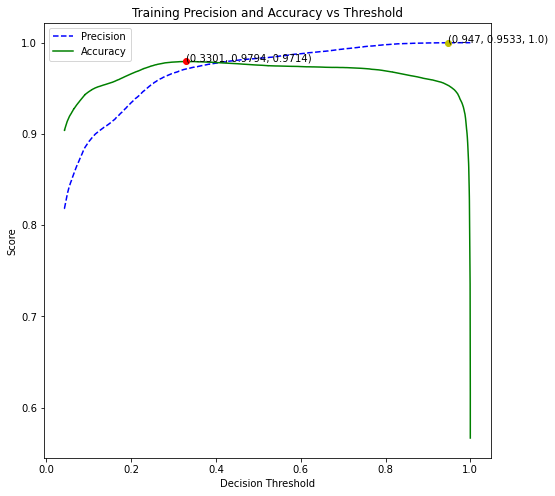

In [37]:
cutoff = find_cutoff(model)
plt.savefig('images/stacking_linear.jpg')
# We use the cutoff where precision is maximized on training data (yellow point, first value of 3)
pred = model.predict_proba(Xtest)[:, 1]

print(f"Linear stacking model -- Precision on test data: {precision_cutoff(ytest, pred, cutoff = cutoff)}")
print(f"Linear stacking model -- Recall on test data: {recall_cutoff(ytest, pred, cutoff = cutoff)}")
print(f"Linear stacking model -- Accuracy on test data: {accuracy_cutoff(ytest, pred, cutoff = cutoff)}")
print(f"Linear stacking model -- Cutoff on test data: {cutoff}")

#### Nonlinear

In [38]:
model = StackingClassifier(estimators = [('rf',m1), ('ada',m2), ('gb',m3), ('xgb',m4)],
                           n_jobs=-1,cv = StratifiedKFold(n_splits=3,shuffle=True,random_state=1))
grid = dict()
grid['final_estimator'] = [RandomForestClassifier(n_estimators=50, max_features=1,random_state=1,oob_score=True),
                          RandomForestClassifier(n_estimators=50, max_features="sqrt",random_state=1,oob_score=True),
                          RandomForestClassifier(n_estimators=50, max_features=14,random_state=1,oob_score=True),
                          RandomForestClassifier(n_estimators=50, max_features=None,random_state=1,oob_score=True)]

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, 
                           verbose=1, scoring=['precision','accuracy'], refit='precision')
grid_result = grid_search.fit(X, y)
print("Best Training Precision: %f\nBest Parameters: %s" % (grid_result.best_score_, grid_result.best_params_))

Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best Training Precision: 0.974121
Best Parameters: {'final_estimator': RandomForestClassifier(max_features=1, n_estimators=50, oob_score=True,
                       random_state=1)}


In [39]:
params = {'final_estimator': RandomForestClassifier(n_estimators=500, max_features=1,random_state=1,oob_score=True)}
en4 = StackingClassifier(**params, estimators = [('rf',m1), ('ada',m2), ('gb',m3), ('xgb',m4)],
                         n_jobs=-1,cv = StratifiedKFold(n_splits=3,shuffle=True,random_state=1))
# model = load_model('stacking_nonlinear')
model = grid_result
pred = model.predict(Xtest)

print(f"Nonlinear stacking model -- Precision on test data: {precision_score(y_true = ytest, y_pred = pred)}")
print(f"Nonlinear stacking model -- Recall on test data: {recall_score(y_true = ytest, y_pred = pred)}")
print(f"Nonlinear stacking model -- Accuracy on test data: {accuracy_score(y_true = ytest, y_pred = pred)}")
print("Nonlinear stacking model -- Cutoff on test data: 0.5")

save_model(model, 'stacking_nonlinear')

Nonlinear stacking model -- Precision on test data: 0.9715164119721493
Nonlinear stacking model -- Recall on test data: 0.9453585569731632
Nonlinear stacking model -- Accuracy on test data: 0.9638512339242267
Nonlinear stacking model -- Cutoff on test data: 0.5


Nonlinear stacking model -- Precision on test data: 1.0
Nonlinear stacking model -- Recall on test data: 1.0
Nonlinear stacking model -- Accuracy on test data: 1.0
Nonlinear stacking model -- Cutoff on test data: 0.0


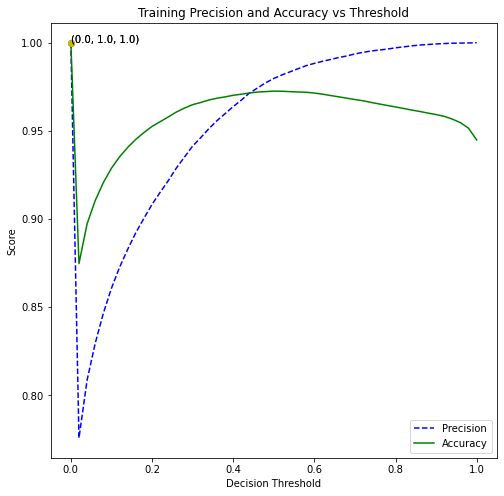

In [40]:
cutoff = find_cutoff(model)
plt.savefig('images/stacking_nonlinear.jpg')
# We use the cutoff where precision is maximized on training data (yellow point, first value of 3)
pred = model.predict_proba(Xtest)[:, 1]

print(f"Nonlinear stacking model -- Precision on test data: {precision_cutoff(ytest, pred, cutoff = cutoff)}")
print(f"Nonlinear stacking model -- Recall on test data: {recall_cutoff(ytest, pred, cutoff = cutoff)}")
print(f"Nonlinear stacking model -- Accuracy on test data: {accuracy_cutoff(ytest, pred, cutoff = cutoff)}")
print(f"Nonlinear stacking model -- Cutoff on test data: {cutoff}")

### Model Importances (Stacking Logistic Regression)

In [41]:
models = ['Random forest', 'AdaBoost', 'Gradient Boost', 'XGBoost']
importances = dict(zip(models, list(coefs[0])))
def importance(val):
    return importances[val]

ordered = sorted(importances, key = importance, reverse = True)

print("Models in order of importance:")
print("-"*50)
for i, model in enumerate(ordered):
    print(f"#{i+1}: {model} ({importances[model]})")

Models in order of importance:
--------------------------------------------------
#1: AdaBoost (12.757848552498661)
#2: Random forest (3.3923974770753493)
#3: XGBoost (0.98194674359408)
#4: Gradient Boost (0.775493753999609)


### Feature Importance Plots

Text(0.5, 1.0, 'Top 5 and Bottom 5 Most Important Features')

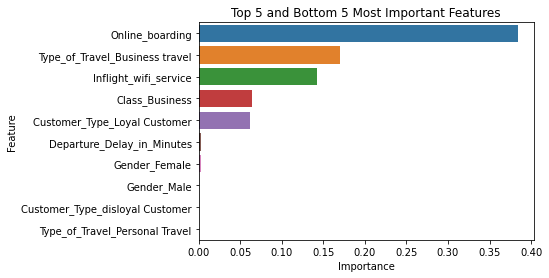

In [48]:
loaded_model = load_model('f4') # old xgb model
importances = [round(feature, 6) for feature in list(loaded_model.feature_importances_)]
feature_data = pd.DataFrame({'Feature': list(X.columns), 'Importance': importances}).sort_values(by = 'Importance', ascending = False)
sns.barplot(y='Feature', x='Importance', data = pd.concat([feature_data.iloc[:5,:], feature_data.iloc[-5:,:]], axis = 0))
plt.title("Top 5 and Bottom 5 Most Important Features")

Some of the takeaways were foreseen. For example, gender is not that important, whereas business class is very important.

### Conclusions

**In order of precision:**

In [ ]:
#TODO

**In order of accuracy:**

In [ ]:
#TODO

**Nonlinear stacking probabilities**

In [51]:
pd.Series(model.predict_proba(Xtest)[:, 1]).value_counts()

0.0000    11227
1.0000     9903
0.0200      660
0.0400      378
0.0600      268
0.0800      255
0.1000      181
0.9800      175
0.1200      166
0.1400      130
0.2000      117
0.1800      116
0.2800      112
0.1600      111
0.2400      110
0.3000      108
0.2200      107
0.2600      107
0.3400       89
0.9600       87
0.3200       87
0.3800       84
0.3600       79
0.4000       77
0.4600       68
0.9400       56
0.5400       56
0.4400       54
0.4200       52
0.5000       51
0.6200       49
0.6000       48
0.6600       47
0.9200       46
0.6400       45
0.8000       44
0.7400       43
0.5600       41
0.5800       41
0.7600       40
0.4800       40
0.8200       39
0.7800       37
0.7200       36
0.5200       35
0.7000       33
0.9000       33
0.6800       33
0.8400       31
0.8800       31
0.8600       30
dtype: int64

Main takeaway: as precision increases, accuracy decreases.

It appears that the best model is the nonlinear stacking model with a cutoff of 0%. It has 100% accuracy on testing data.
Surprisingly, it either predicts 0% or 100% probability of satisfaction for the majority of observations.